Here is the second LSTM model. Everything is the same, but the Standard Scaler is used here.

For training, the scaler is trained based on the whole training set; For forcasting, the scaler is defined locally, based on the data of past N days which are the features of the model.

Such kind of mixed/hybridized way turns out to be crutial, in the way of:  
* Training data are fully used
* During forcasting, all the predictions are anchored to the rolling mean and std

In such a way, this LSTM model with the standardscaler is finally as good as the persistence model (both with MAPE~1,75).

In [2]:
import math
import numpy as np
import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from numpy.random import seed

from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

train = data[:ntrain]
val = data[ntrain:ntrain+nval]
train_val = data[:ntrain+nval] # convinient
test = data[ntrain+nval:]
print("Dataset Size:")
print("Train: {} | Validation: {} | Test: {}".format(train.shape[0],
                                                       val.shape[0],
                                                      test.shape[0]))

data.head(5)

Dataset Size:
Train: 891 | Validation: 297 | Test: 297


,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### EDA

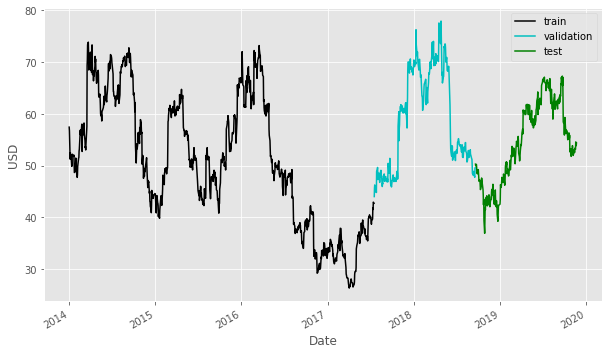

In [4]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

### Modelling

In [5]:
# functions for wrapping codes

def get_x_y(data, N, start):
    x, y = [], []
    for i in range(start, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, start):
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(start, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-start])/std_list[i-start])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list


def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_test_scaled, \
                          y_test, \
                          mu_test_list, \
                          std_test_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1,
                          name='Algo'):
    
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    y_pred_scaled = model.predict(x_test_scaled)
    y_pred = (y_pred_scaled * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

    # Calculate RMSE and MAPE
    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred

#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params_tuning(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();

#### Dryrun

In [6]:
# initial parameters 

N = 5                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=64                  # lstm param. initial value before tuning.
dropout_prob=0.0               # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=20                      # lstm param. initial value before tuning.
batch_size=16                  # lstm param. initial value before tuning.

seed(42)
set_seed(42)

In [7]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)

x_val_scaled, y_val, mu_val_list, std_val_list = get_x_scaled_y(np.array(train_val['adj_close']).reshape(-1,1), N, ntrain)

scaler_final = StandardScaler()
train_val_scaled_final = scaler_final.fit_transform(np.array(train_val['adj_close']).reshape(-1,1))

In [8]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

model.summary()

Epoch 1/20
56/56 - 1s - loss: 0.2124
Epoch 2/20
56/56 - 1s - loss: 0.0439
Epoch 3/20
56/56 - 1s - loss: 0.0425
Epoch 4/20
56/56 - 1s - loss: 0.0413
Epoch 5/20
56/56 - 1s - loss: 0.0389
Epoch 6/20
56/56 - 1s - loss: 0.0367
Epoch 7/20
56/56 - 1s - loss: 0.0349
Epoch 8/20
56/56 - 1s - loss: 0.0325
Epoch 9/20
56/56 - 1s - loss: 0.0300
Epoch 10/20
56/56 - 1s - loss: 0.0276
Epoch 11/20
56/56 - 1s - loss: 0.0246
Epoch 12/20
56/56 - 1s - loss: 0.0245
Epoch 13/20
56/56 - 1s - loss: 0.0220
Epoch 14/20
56/56 - 1s - loss: 0.0207
Epoch 15/20
56/56 - 1s - loss: 0.0202
Epoch 16/20
56/56 - 1s - loss: 0.0187
Epoch 17/20
56/56 - 1s - loss: 0.0175
Epoch 18/20
56/56 - 1s - loss: 0.0174
Epoch 19/20
56/56 - 1s - loss: 0.0169
Epoch 20/20
56/56 - 1s - loss: 0.0175


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Do prediction
y_pred_scaled = model.predict(x_val_scaled)
y_pred = (y_pred_scaled * np.array(std_val_list).reshape(-1,1)) + np.array(mu_val_list).reshape(-1,1)

m = forecast_metrics(y_val, y_pred, 'LSTM_Dryrun')

print(m)

                 RMSE      MAPE     SMAPE    MinMax      Corr
LSTM_Dryrun  1.725246  1.928378  1.930193  1.890701  0.983883


In [10]:
rmse_bef_tuning = m.RMSE[0]
mape_pct_bef_tuning = m.MAPE[0]

#### Plotting on Valication set

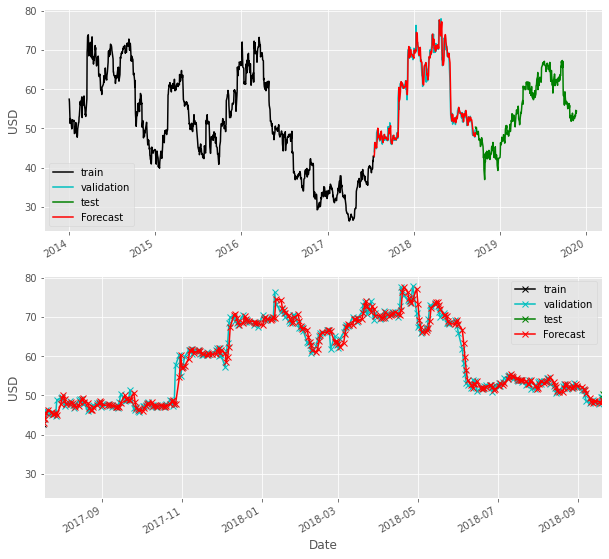

In [11]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Tuning N (no. of days to use as features)

In [12]:
metrics = pd.DataFrame()

# N start from 2
for param in range(2,60):

    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)
    x_val_scaled, y_val, mu_val_list, std_val_list = get_x_scaled_y(np.array(train_val['adj_close']).reshape(-1,1), param, ntrain)
    
    # Train, predict and eval model
    m, _ = train_pred_eval_model( x_train_scaled, \
                                  y_train_scaled, \
                                  x_val_scaled, \
                                  y_val, \
                                  mu_val_list, \
                                  std_val_list, \
                                  lstm_units=lstm_units, \
                                  dropout_prob=dropout_prob, \
                                  optimizer='adam', \
                                  epochs=epochs, \
                                  batch_size=batch_size,
                                  name=param)
    metrics = metrics.append(m)
    print("|", end = '...')
    
print('!')
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 

print(metrics)
N_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...!
15 1.8557199569124212
        RMSE      MAPE     SMAPE    MinMax      Corr
2   1.839166  2.060244  2.066596  2.021824  0.981612
3   1.832864  2.051672  2.058314  2.013878  0.981714
4   1.756040  1.961730  1.966138  1.925224  0.983247
5   1.745134  1.952473  1.955496  1.915115  0.983487
6   1.699918  1.898041  1.900682  1.862310  0.984333
7   1.665630  1.858414  1.859193  1.822258  0.984978
8   1.672535  1.868489  1.870379  1.832959  0.984814
9   1.673822  1.863027  1.865897  1.828484  0.984787
10  1.685665  1.871307  1.872109  1.834174  0.984579
11  1.677048  1.872935  1.875217  1.837706  0.984741
12  1.674022  1.863614  1.866994  1.829470  0.984759
13  1.665162  1.861110  1.865277  1.828175  0.984956
14  1.716497  1.908390  1.912797  1.873389  0.983972
15

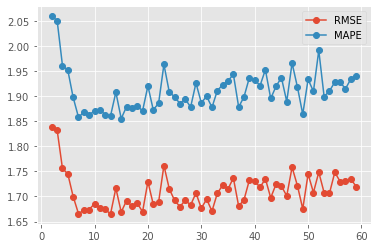

In [13]:
metrics[['RMSE', 'MAPE']].plot(style='o-');

In [14]:
metrics.sort_values(by='MAPE').head(5)

,RMSE,MAPE,SMAPE,MinMax,Corr
15,1.668937,1.855720,1.859468,1.822087,0.984838
7,1.665630,1.858414,1.859193,1.822258,0.984978
13,1.665162,1.861110,1.865277,1.828175,0.984956
9,1.673822,1.863027,1.865897,1.828484,0.984787
12,1.674022,1.863614,1.866994,1.829470,0.984759


In [15]:
### Tuning model - epochs and batch_size

param_label = 'epochs'
param_list = [1, 10, 20, 30, 50, 100]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
x_val_scaled, y_val, mu_val_list, std_val_list = get_x_scaled_y(np.array(train_val['adj_close']).reshape(-1,1), N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model( x_train_scaled, \
                                      y_train_scaled, \
                                      x_val_scaled, \
                                      y_val, \
                                      mu_val_list, \
                                      std_val_list, \
                                      lstm_units=lstm_units, \
                                      dropout_prob=dropout_prob, \
                                      optimizer='adam', \
                                      epochs=param, \
                                      batch_size=param2,
                                      name=(param, param2)
                                    )
        metrics = metrics.append(m)
        print("|", end = '...')
    
print('!')
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

epochs_opt, batch_size_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...!
(50, 8) 1.808357571566966
                RMSE      MAPE     SMAPE    MinMax      Corr
(1, 8)      2.983037  3.389290  3.384752  3.267631  0.951540
(1, 16)     3.474001  3.972043  3.965299  3.804806  0.934471
(1, 32)     3.534449  4.041380  4.034418  3.868189  0.932220
(1, 64)     3.849393  4.400744  4.389637  4.193039  0.920058
(1, 128)    3.641578  4.163020  4.151518  3.974725  0.928078
(10, 8)     1.726681  1.917180  1.920989  1.881008  0.983780
(10, 16)    1.777017  1.974498  1.979771  1.937691  0.982831
(10, 32)    2.309608  2.589140  2.588374  2.519222  0.971042
(10, 64)    2.734397  3.114662  3.113173  3.015710  0.959349
(10, 128)   3.296963  3.763178  3.756332  3.612306  0.940895
(20, 8)     1.676780  1.862187  1.865862  1.828084  0.984717
(20, 16)    1.690655  1.875653  1.878538  1.840231  0.984445
(20, 32)    1.729269  1.915189  1.920756  1.880809  0.98372

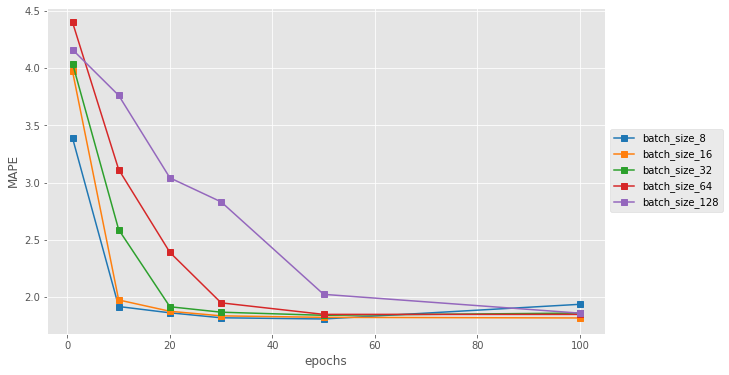

In [16]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [17]:
### Tuning model - LSTM units and dropout prob

param_label = 'lstm_units'
param_list = [32, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

#x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
#x_val_scaled, y_val, mu_val_list, std_val_list = get_x_scaled_y(np.array(train_val['adj_close']).reshape(-1,1), N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(x_train_scaled, \
                                     y_train_scaled, \
                                     x_val_scaled, \
                                     y_val, \
                                     mu_val_list, \
                                     std_val_list, \
                                     lstm_units=param, \
                                     dropout_prob=param2, \
                                     optimizer='adam', \
                                     epochs=epochs_opt, \
                                     batch_size=batch_size_opt,
                                     name=(param, param2)
                                    )
        # collect metrics
        metrics = metrics.append(m)
        print("|", end='...')
        
print('!')
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

lsmt_units_opt, dropout_prob_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...!
(64, 0.0) 1.801725969007923
                RMSE      MAPE     SMAPE    MinMax      Corr
(32, 0.0)   1.657586  1.838734  1.844703  1.807711  0.985059
(32, 0.1)   1.676968  1.851169  1.855669  1.818043  0.984698
(32, 0.2)   1.704425  1.885319  1.888751  1.849932  0.984174
(32, 0.3)   1.750697  1.940634  1.943843  1.903000  0.983321
(32, 0.4)   1.815997  1.998650  1.998087  1.954267  0.982062
(32, 0.5)   1.898243  2.079925  2.078724  2.030981  0.980390
(32, 0.6)   1.983633  2.157417  2.159775  2.107602  0.978511
(32, 0.7)   2.092525  2.265574  2.266936  2.208849  0.976046
(32, 0.8)   2.286938  2.506180  2.502281  2.433052  0.971356
(50, 0.0)   1.624844  1.811531  1.817280  1.781756  0.985653
(50, 0.1)   1.647868  1.826346  1.830306  1.793854  0.985206
(50, 0.2)   1.674875  1.852484  1.855221  1.817649  0.984714
(50, 0.3)   1.690306  1.873306  1

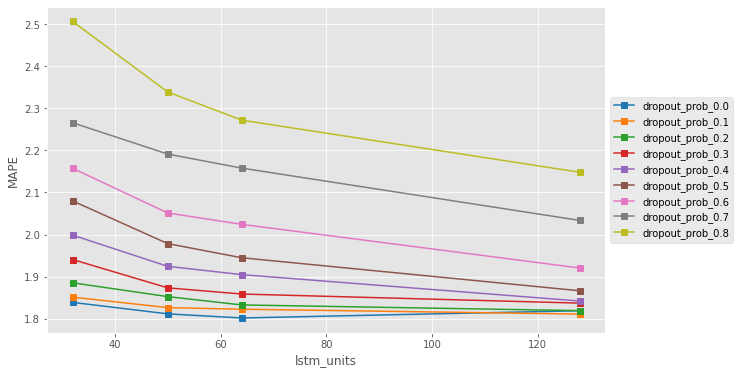

In [18]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [19]:
param_label = 'learning_rate'
param_list = [3e-4, 1e-3, 1e-2, 1e-1]

param2_label = 'epochs2'  # epochs_opt = 20
param2_list = [20, 40, 80, 100, 200, 300, 400]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
x_val_scaled, y_val, mu_val_list, std_val_list = get_x_scaled_y(np.array(train_val['adj_close']).reshape(-1,1), N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        
        # Train, predict and eval model
        m, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_val_scaled, \
                                              y_val, \
                                              mu_val_list, \
                                              std_val_list, \
                                              lstm_units=lsmt_units_opt, \
                                              dropout_prob=dropout_prob_opt, \
                                              optimizer=keras.optimizers.Adam(lr=param, beta_1=0.9, beta_2=0.999), \
                                              epochs=param2, \
                                              batch_size=batch_size_opt,
                                              name=(param, param2)
                                             )
        # collect metrics
        metrics = metrics.append(m)
        print("|", end='...')
        
print('!')
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

learning_rate_opt, epochs2_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...!
(0.0003, 80) 1.827379015450693
                   RMSE      MAPE     SMAPE    MinMax      Corr
(0.0003, 20)   1.720137  1.904319  1.911318  1.871755  0.983922
(0.0003, 40)   1.658076  1.856954  1.861889  1.825079  0.985076
(0.0003, 80)   1.626651  1.827379  1.831324  1.795813  0.985638
(0.0003, 100)  1.632980  1.830439  1.834133  1.798350  0.985526
(0.0003, 200)  1.672787  1.903225  1.903352  1.865674  0.985004
(0.0003, 300)  1.840313  2.209833  2.200124  2.155539  0.982978
(0.0003, 400)  1.981413  2.366253  2.354525  2.303609  0.980118
(0.001, 20)    1.669045  1.853375  1.857538  1.820130  0.984855
(0.001, 40)    1.630499  1.839439  1.843470  1.807846  0.985621
(0.001, 80)    1.654473  1.852130  1.851308  1.814837  0.985344
(0.001, 100)   1.689240  1.908821  1.904753  1.866920  0.985023
(0.001, 200)   2.079291  2.407488  2.395488  2.339730  0.977603
(0.001, 300)   2.281491

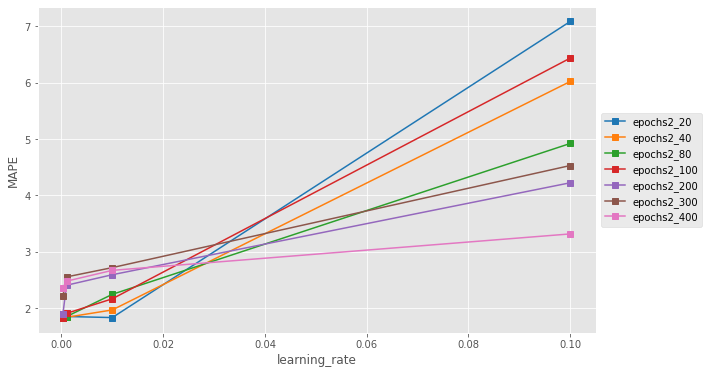

In [20]:
plot_two_params_tuning(metrics, param_label, param2_label) 

# the figure seems wrong? should plot log scale for x

### Final model, test set

In [21]:
# check final parameters:
epochs_opt = epochs2_opt
lsmt_units_opt, dropout_prob_opt, learning_rate_opt, epochs_opt, batch_size_opt

(64, 0.0, 0.0003, 80, 8)

In [22]:
x_train_val_scaled, y_train_val_scaled = get_x_y(train_val_scaled_final, N_opt, N_opt)
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(data['adj_close']).reshape(-1,1), N_opt, ntrval)

# Train, predict and eval model
metrics, y_pred = train_pred_eval_model(x_train_val_scaled, \
                                      y_train_val_scaled, \
                                      x_test_scaled, \
                                      y_test, \
                                      mu_test_list, \
                                      std_test_list, \
                                      lstm_units=lsmt_units_opt, \
                                      dropout_prob=dropout_prob_opt, \
                                      optimizer=keras.optimizers.Adam(lr=learning_rate_opt, beta_1=0.9, beta_2=0.999), \
                                      epochs=epochs_opt, \
                                      batch_size=batch_size_opt,
                                      name='lstm'
                                     )

print(metrics)
test[f'forcast'] = y_pred

          RMSE      MAPE     SMAPE    MinMax      Corr
lstm  1.262472  1.754433  1.751003  1.723143  0.986802


### Plotting on test set

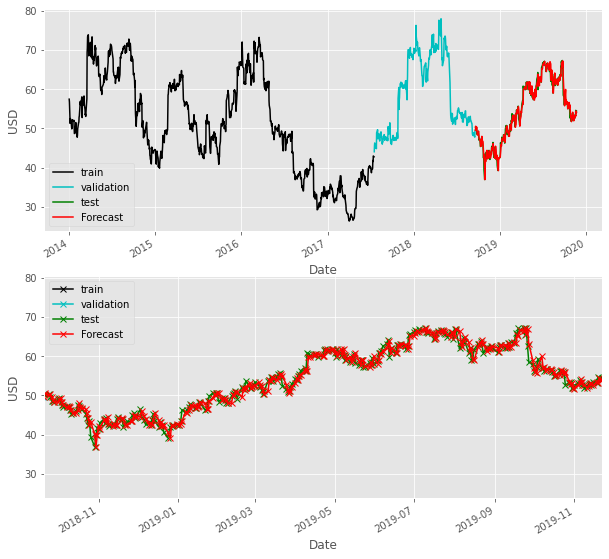

In [23]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [24]:
test.to_csv("./out/test_lstm_std.csv")

In [25]:
print(metrics)

          RMSE      MAPE     SMAPE    MinMax      Corr
lstm  1.262472  1.754433  1.751003  1.723143  0.986802
